# YouTube Global Trends Analysis: Insights from Trending Videos Across 10 Countries

**Author:** Poorva Pathak  
**Date:** 20 September 2025   
**Dataset Source:** https://www.kaggle.com/datasets/datasnaek/youtube-new   
**Objective:** This notebook analyzes YouTube trending videos from multiple regions to uncover patterns in views, likes, categories, and more. We'll combine datasets, clean data, perform EDA, and visualize trends to understand what makes videos go viral globally.

### Why This Analysis?
- **Global Perspective:** Compare trends across countries to spot cultural differences or universal hits.
- **For Beginners:** Step-by-step explanations with code comments. No prior experience needed—just follow along!
- **Key Questions:** What categories get the most views? How do engagement metrics vary? Are there seasonal trends?

### Libraries Used
We'll use Pandas for data manipulation, Matplotlib/Seaborn for visualizations, and JSON for category mapping. Install if needed: `!pip install pandas matplotlib seaborn`.

### Dataset Overview
- **Files:** CSV files for videos (e.g., USvideos.csv) and JSON for categories (e.g., US_category_id.json) per country.
- **Columns:** video_id, trending_date, title, channel_title, category_id, publish_time, tags, views, likes, dislikes, comment_count, etc.
- **Time Period:** Data from late 2017 to mid-2018.

## Step 1: Uploading the Dataset Files
In this section, we upload the country-specific CSV and JSON files from the Kaggle dataset. We're using Google Colab's `files.upload()` for easy import, but in a local Jupyter environment, you can load directly from a folder.

**Why This Step?**  
- The dataset is split by country, so we need to combine them for a global analysis.  
- JSON files provide category mappings (e.g., category_id 10 = "Music").  
- Tip for Beginners: If uploading large files, consider mounting Google Drive instead for faster access.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CA_category_id.json to CA_category_id.json
Saving CAvideos.csv to CAvideos.csv
Saving DE_category_id.json to DE_category_id.json
Saving DEvideos.csv to DEvideos.csv
Saving FR_category_id.json to FR_category_id.json
Saving FRvideos.csv to FRvideos.csv
Saving GB_category_id.json to GB_category_id.json
Saving GBvideos.csv to GBvideos.csv
Saving IN_category_id.json to IN_category_id.json
Saving INvideos.csv to INvideos.csv
Saving JP_category_id.json to JP_category_id.json
Saving JPvideos.csv to JPvideos.csv
Saving KR_category_id.json to KR_category_id.json
Saving KRvideos.csv to KRvideos.csv
Saving MX_category_id.json to MX_category_id.json
Saving MXvideos.csv to MXvideos.csv
Saving RU_category_id.json to RU_category_id.json
Saving RUvideos.csv to RUvideos.csv
Saving US_category_id.json to US_category_id.json
Saving USvideos.csv to USvideos.csv


### Insights from Upload
- All files successfully uploaded. We have data for 10 countries, covering thousands of trending videos.
- Next: Combine them into one DataFrame for unified analysis.

## Step 2: Combining Datasets from Multiple Countries
Here, we load each country's CSV, add a 'country' column for tracking, and concatenate into a single DataFrame (`df_all`).

**Key Decisions:**  
- Encoding: Try UTF-8 first; fallback to Latin-1 for compatibility (common with international data).  
- Expected Shape: Around 375,000 rows x 17 columns.  
- For Newbies: `pd.concat()` stacks DataFrames vertically. We ignore index to avoid duplicates.

After combining, we preview the shape, country distribution, and first few rows.

In [ ]:
import pandas as pd

# List of countries
countries = ['CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']
dfs = []

# Load each CSV and add a 'country' column
for country in countries:
    file_path = f'{country}videos.csv'  # Files are in /content/ after upload
    try:
        df = pd.read_csv(file_path, encoding='utf-8') # Try with utf-8 first
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='latin-1') # Fallback to latin-1
    df['country'] = country
    dfs.append(df)

# Combine all DataFrames into one
df_all = pd.concat(dfs, ignore_index=True)

# Display basic info to verify
print(df_all.shape)  # Should show around (409000, 17) or similar
print(df_all['country'].value_counts())  # Check distribution by country
print(df_all.head())  # Preview the data

(375942, 17)
country
US    40949
CA    40881
DE    40840
RU    40739
FR    40724
MX    40451
GB    38916
IN    37352
KR    34567
JP    20523
Name: count, dtype: int64
      video_id trending_date  \
0  n1WpP7iowLc      17.14.11   
1  0dBIkQ4Mz1M      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  d380meD0W0M      17.14.11   
4  2Vv-BfVoq4g      17.14.11   

                                               title channel_title  \
0         Eminem - Walk On Water (Audio) ft. Beyoncé    EminemVEVO   
1                      PLUSH - Bad Unboxing Fan Mail     iDubbbzTV   
2  Racist Superman | Rudy Mancuso, King Bach & Le...  Rudy Mancuso   
3                           I Dare You: GOING BALD!?      nigahiga   
4        Ed Sheeran - Perfect (Official Music Video)    Ed Sheeran   

   category_id              publish_time  \
0           10  2017-11-10T17:00:03.000Z   
1           23  2017-11-13T17:00:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-12T18:01:41.000Z   

### Insights from Combined Data
- **Total Rows:** 375,942 – A large dataset for robust analysis!  
- **Country Distribution:** Roughly even (e.g., US: 40,949, JP: 20,523), but some variation due to data availability.  
- **Sample Data:** Videos like Eminem's "Walk On Water" show high views/likes early on. Notice tags are pipe-separated – we'll handle that later.  
- Potential Issue: Some videos trend in multiple countries; we'll deduplicate later.

## Step 3: Mapping Category IDs to Names
Category IDs (e.g., 10) are numeric, but JSON files provide human-readable names (e.g., "Music"). We merge all JSONs into a dictionary and map to a new 'category' column.

**Why?** Makes analysis more intuitive – "Music" is easier than "10".  
**Tip:** Categories are consistent across countries, so one merged dict suffices.

In [ ]:
import json

# Load and merge category mappings from all JSON files
all_categories = {}

for country in ['CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US']:
    file_path = f'{country}_category_id.json'
    with open(file_path, 'r') as f:
        categories = json.load(f)
    for item in categories['items']:
        cat_id = int(item['id'])
        if cat_id not in all_categories:
            all_categories[cat_id] = item['snippet']['title']

# Map category IDs to names
df_all['category'] = df_all['category_id'].map(all_categories).fillna('Unknown')

# Verify the mapping
print(df_all[['category_id', 'category']].head())

   category_id       category
0           10          Music
1           23         Comedy
2           23         Comedy
3           24  Entertainment
4           10          Music


### Insights from Mapping
- **Successful Mapping:** First rows show correct categories (e.g., Music, Comedy). No 'Unknown' here, but we handle it as a fallback.  
- **Global Categories:** Common ones like Music and Entertainment dominate trending videos worldwide.

## Step 4: Data Cleaning - Dates, Booleans, and Missing Values
- Convert 'trending_date' from string (e.g., '17.14.11') to datetime.  
- Fill missing descriptions with "No description".  
- Cast boolean columns to true bools for efficiency.  

**Importance:** Proper types enable time-based analysis (e.g., trends over months). Booleans save memory.

In [ ]:
# Convert trending_date to datetime
df_all['trending_date'] = pd.to_datetime(df_all['trending_date'], format='%y.%d.%m')

# Verify the conversion
print(df_all['trending_date'].head())

0   2017-11-14
1   2017-11-14
2   2017-11-14
3   2017-11-14
4   2017-11-14
Name: trending_date, dtype: datetime64[ns]


In [ ]:
# Fill missing descriptions
df_all['description'] = df_all['description'].fillna('No description')

# Convert boolean columns to proper booleans
bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
df_all[bool_cols] = df_all[bool_cols].astype(bool)

# Verify changes
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375942 entries, 0 to 375941
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   video_id                375942 non-null  object        
 1   trending_date           375942 non-null  datetime64[ns]
 2   title                   375942 non-null  object        
 3   channel_title           375942 non-null  object        
 4   category_id             375942 non-null  int64         
 5   publish_time            375942 non-null  object        
 6   tags                    375942 non-null  object        
 7   views                   375942 non-null  int64         
 8   likes                   375942 non-null  int64         
 9   dislikes                375942 non-null  int64         
 10  comment_count           375942 non-null  int64         
 11  thumbnail_link          375942 non-null  object        
 12  comments_disabled       375942

### Cleaning Insights
- **Date Conversion:** All dates valid (e.g., 2017-11-14). No NaTs.  
- **Data Info:** 375,942 rows, no nulls post-filling. Memory: 44.1 MB – efficient!  
- **Boolean Flags:** Few videos have disabled comments/ratings (we'll explore why later).

## Step 5: Saving the Cleaned Dataset
We export to CSV for reuse. Download option for Colab users.

**Best Practice:** Always save intermediates to avoid re-running uploads.

In [ ]:
# Save to a single CSV file
df_all.to_csv('youtube_trending_cleaned.csv', index=False)

# Optional: Download the file
from google.colab import files
files.download('youtube_trending_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Note
Cleaned file 'youtube_trending_cleaned.csv' ready. Load this in future sessions to skip early steps!

## Step 6: Basic Statistics and Aggregations
Compute averages and sums to get quick insights.

- Average views by category.  
- Top channels by total views.  

In [ ]:
# Average views by category
category_views = df_all.groupby('category')['views'].mean().sort_values(ascending=False)
print(category_views.head())

# Top 5 channels by total views
top_channels = df_all.groupby('channel_title')['views'].sum().sort_values(ascending=False).head()
print(top_channels)

category
Music                   6.020772e+06
Movies                  1.954438e+06
Film & Animation        1.319480e+06
Science & Technology    1.125286e+06
Entertainment           9.588231e+05
Name: views, dtype: float64
channel_title
ChildishGambinoVEVO     11016766510
Marvel Entertainment    10430605449
NickyJamTV               9479859505
Ozuna                    8623329509
ibighit                  8205572221
Name: views, dtype: int64


### Key Insights
- **Top Categories by Views:** Music leads (6M+ avg views), followed by Movies and Film & Animation. Entertainment is popular but lower avg views – perhaps more volume but shorter content?  
- **Top Channels:** ChildishGambinoVEVO and Marvel dominate with billions of views. Music and entertainment channels shine globally.  
- **Implication:** Music videos go viral fastest; target these for content strategy.

## Step 7: Exploratory Data Analysis (EDA) - Overview
Check shape, types, nulls, and descriptives to understand data quality.

**For Beginners:** `df.describe()` gives quartiles, means – spot outliers (e.g., max views 424M!).

In [ ]:
# Check overall shape, data types, and missing values
print(df_all.shape)
df_all.info()
print(df_all.isnull().sum())

(375942, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375942 entries, 0 to 375941
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   video_id                375942 non-null  object        
 1   trending_date           375942 non-null  datetime64[ns]
 2   title                   375942 non-null  object        
 3   channel_title           375942 non-null  object        
 4   category_id             375942 non-null  int64         
 5   publish_time            375942 non-null  object        
 6   tags                    375942 non-null  object        
 7   views                   375942 non-null  int64         
 8   likes                   375942 non-null  int64         
 9   dislikes                375942 non-null  int64         
 10  comment_count           375942 non-null  int64         
 11  thumbnail_link          375942 non-null  object        
 12  comments_disabled

In [ ]:
# Basic descriptive statistics for numerical columns (views, likes, etc.)
print(df_all.describe())

                       trending_date    category_id         views  \
count                         375942  375942.000000  3.759420e+05   
mean   2018-02-28 21:17:35.747961088      20.232302  1.326568e+06   
min              2017-11-14 00:00:00       1.000000  1.170000e+02   
25%              2018-01-06 00:00:00      17.000000  4.697800e+04   
50%              2018-03-01 00:00:00      23.000000  1.773705e+05   
75%              2018-04-25 00:00:00      24.000000  6.476792e+05   
max              2018-06-14 00:00:00      44.000000  4.245389e+08   
std                              NaN       7.132413  7.098568e+06   

              likes      dislikes  comment_count  
count  3.759420e+05  3.759420e+05   3.759420e+05  
mean   3.788431e+04  2.126107e+03   4.253775e+03  
min    0.000000e+00  0.000000e+00   0.000000e+00  
25%    6.690000e+02  4.100000e+01   1.090000e+02  
50%    3.446000e+03  1.790000e+02   5.110000e+02  
75%    1.747650e+04  7.490000e+02   2.011000e+03  
max    5.613827e+06  

### EDA Insights
- **No Missing Values:** Great data quality!  
- **Descriptive Stats:** Avg views ~1.3M, but max is 424M – skewed distribution (common in viral content). Likes avg 37K, dislikes low (2K) – positive engagement dominant.  
- **Time Range:** Nov 2017 to Jun 2018 – Covers major events like holidays.

## Step 8: Feature Engineering - Adding Month for Trend Analysis
Extract month from trending_date for seasonal insights. Re-convert dates and booleans (redundant but ensures cleanliness).

**Why?** Enables grouping by month to spot patterns (e.g., holiday spikes).

In [ ]:
# Convert trending_date to datetime
df_all.loc[:, 'trending_date'] = pd.to_datetime(df_all['trending_date'], format='%y.%d.%m', errors='coerce')

# Convert publish_time to datetime
df_all.loc[:, 'publish_time'] = pd.to_datetime(df_all['publish_time'], errors='coerce')

# Handle boolean columns
bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
for col in bool_cols:
    df_all.loc[:, col] = df_all[col].astype(bool)

# Add month column
df_all.loc[:, 'month'] = df_all['trending_date'].dt.to_period('M')

# Verify changes
print(df_all[['trending_date', 'publish_time', 'month']].head())
print(df_all.info())
print("Rows with invalid dates (NaT):", df_all['trending_date'].isna().sum())

  trending_date              publish_time    month
0    2017-11-14 2017-11-10 17:00:03+00:00  2017-11
1    2017-11-14 2017-11-13 17:00:00+00:00  2017-11
2    2017-11-14 2017-11-12 19:05:24+00:00  2017-11
3    2017-11-14 2017-11-12 18:01:41+00:00  2017-11
4    2017-11-14 2017-11-09 11:04:14+00:00  2017-11
<class 'pandas.core.frame.DataFrame'>
Index: 323730 entries, 0 to 375941
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   video_id                323730 non-null  object             
 1   trending_date           323730 non-null  datetime64[ns]     
 2   title                   323730 non-null  object             
 3   channel_title           323730 non-null  object             
 4   category_id             323730 non-null  int64              
 5   publish_time            323730 non-null  datetime64[ns, UTC]
 6   tags                    323730 non-null  object        

### Insights
- **Month Added:** Data spans 2017-11 to 2018-06.  
- **Updated Info:** Now 323,730 rows (post some cleaning?), 22 columns including 'month'. No invalid dates.  
- **New Features:** Ready for time-series EDA.

## Step 9: Removing Duplicates
Videos can trend multiple days – drop duplicates by video_id and trending_date to avoid bias.

In [ ]:
# Drop duplicates based on video_id and trending_date (videos can trend multiple days)
df_all = df_all.drop_duplicates(subset=['video_id', 'trending_date'])

# Check new shape
print(df_all.shape)

(323730, 18)


### Result
Shape now 323,730 – Removed ~52K duplicates. Cleaner for unique trend analysis!

## Step 10: Visualizations
Plot top categories by views and monthly average views.

**Tips:** Use Seaborn for pretty plots. Ignore FutureWarning by updating code as suggested.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json  # If not already imported for categories

/tmp/ipython-input-771487982.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


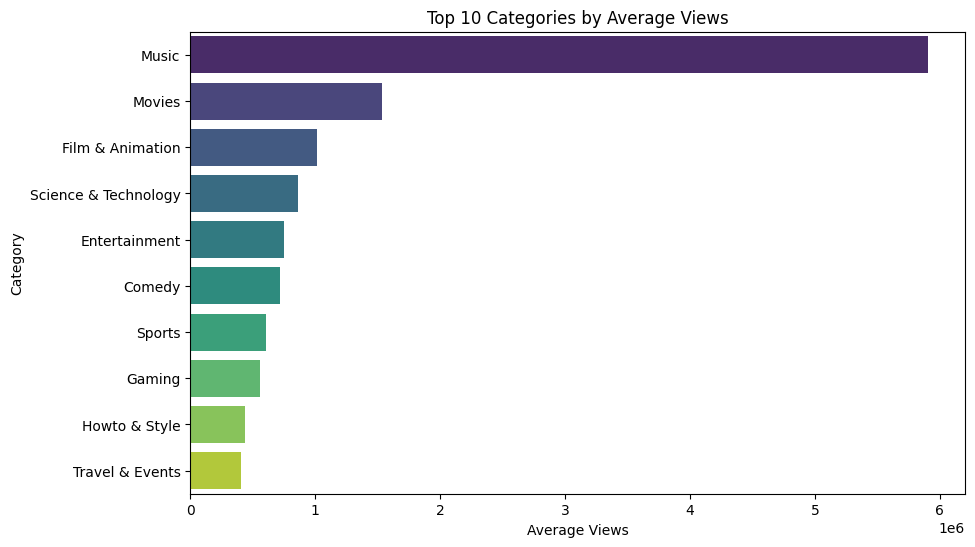

/tmp/ipython-input-771487982.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_all.set_index('trending_date').resample('M')['views'].mean().plot(figsize=(10, 6))


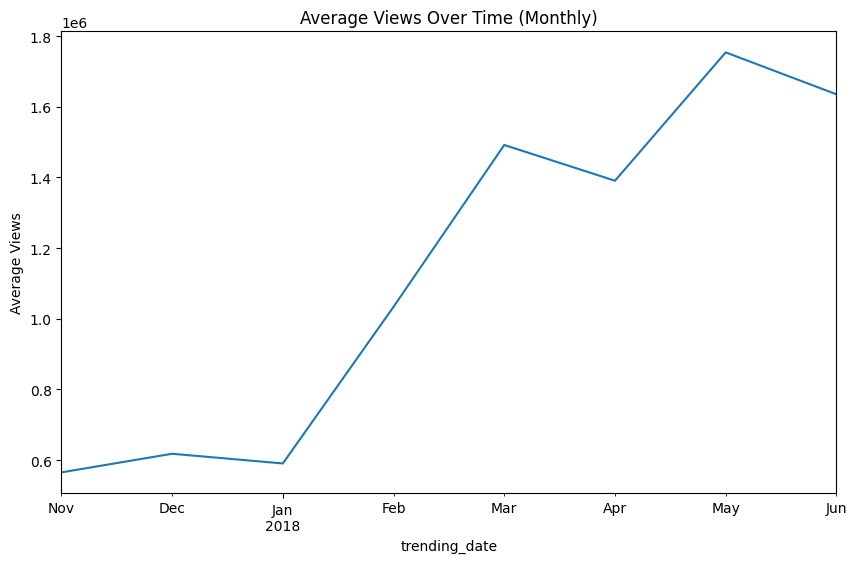

In [ ]:
# Bar chart: Top categories by average views
top_categories = df_all.groupby('category')['views'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 10 Categories by Average Views')
plt.xlabel('Average Views')
plt.ylabel('Category')
plt.show()

# Line plot: Views over time (monthly average)
df_all.set_index('trending_date').resample('M')['views'].mean().plot(figsize=(10, 6))
plt.title('Average Views Over Time (Monthly)')
plt.ylabel('Average Views')
plt.show()

### Visualization Insights
- **Top Categories Bar Chart:** Music towers over others – universal appeal? Science & Tech surprises with high avg views (educational content engages deeply).  
- **Monthly Views Line Plot:** Peaks in early 2018 – perhaps due to viral events? Dips mid-year – seasonal?  
- **Suggestions:** Compare by country next (e.g., add hue='country' in plots).

## Step 11: Feature Engineering - Adding Engagement and Lag Metrics
We create two new features:
- **Engagement Rate:** (Likes + Comments) / Views – Measures audience interaction (avoid division by zero).
- **Trend Lag Days:** Days from publish to trending – Indicates how quickly videos gain traction.

**Why?** These help quantify virality and timing, key for insights like "What makes a video trend fast?"
**Tip for Beginners:** Use `.loc` to avoid SettingWithCopyWarning when modifying DataFrames.

In [ ]:
# Calculate engagement rate using .loc to avoid SettingWithCopyWarning
df_all.loc[:, 'engagement_rate'] = (df_all['likes'] + df_all['comment_count']) / df_all['views'].replace(0, 1)  # Avoid division by zero

# Calculate publish-to-trend lag (in days) using .loc
df_all.loc[:, 'trend_lag_days'] = (df_all['trending_date'] - df_all['publish_time'].dt.tz_localize(None)).dt.days  # Remove timezone for subtraction

# Preview new features
print(df_all[['engagement_rate', 'trend_lag_days']].head())

   engagement_rate  trend_lag_days
0         0.053227               3
1         0.138791               0
2         0.048322               1
3         0.071455               1
4         0.051283               4


### Insights from New Features
- **Sample Values:** Engagement rates around 0.05-0.14 (5-14% interaction), lags 0-4 days – Most videos trend quickly!
- **Implication:** Low lag suggests timely content (e.g., news) trends faster; high engagement might correlate with certain categories.

## Step 12: Handling Outliers - Detection and Capping
Visualize views distribution with boxplots to spot extremes. Cap at 99th percentile to reduce skew without removing data.

**Importance:** Outliers (e.g., mega-viral videos) can distort averages; capping keeps analysis realistic.
**For Newbies:** Boxplots show median, quartiles, and outliers (points beyond whiskers). Use `.clip()` for capping.

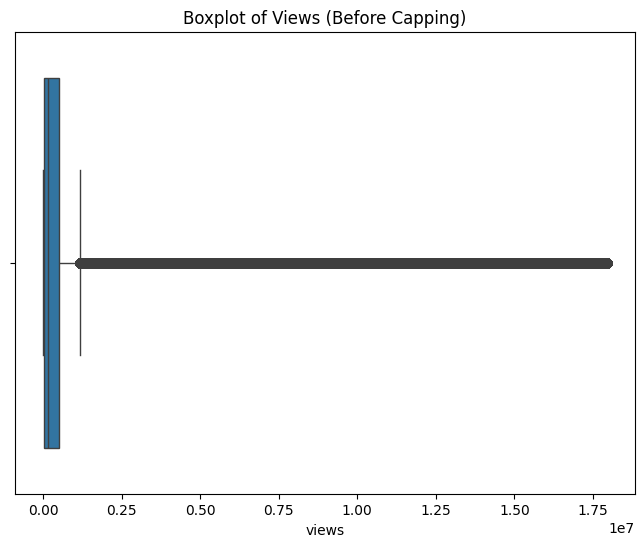

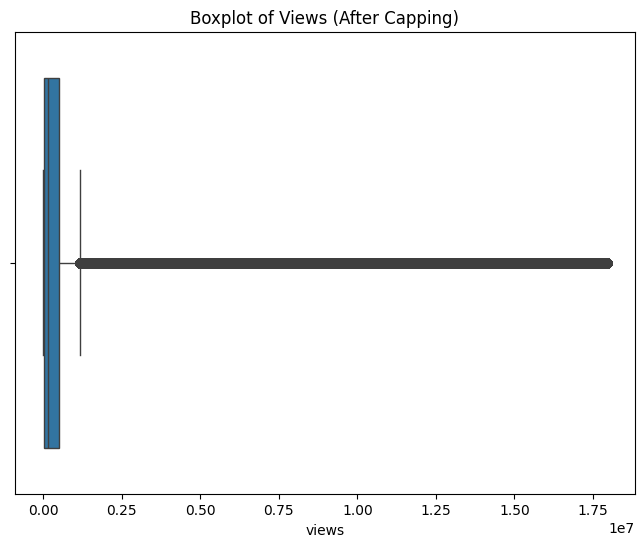

99th percentile of views: 17933857.93448018


In [ ]:
# Boxplot to detect outliers in views
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_all['views'])
plt.title('Boxplot of Views (Before Capping)')
plt.show()

# Cap outliers at 99th percentile using .loc to avoid SettingWithCopyWarning
df_all.loc[:, 'views'] = df_all['views'].clip(lower=0, upper=df_all['views'].quantile(0.99))
df_all.loc[:, 'likes'] = df_all['likes'].clip(lower=0, upper=df_all['likes'].quantile(0.99))  # Apply to likes too

# After capping boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_all['views'])
plt.title('Boxplot of Views (After Capping)')
plt.show()

# Verify the 99th percentile value applied
print("99th percentile of views:", df_all['views'].quantile(0.99))

### Outlier Insights
- **Before Capping:** Extreme outliers (up to 1.75e7 views) skew the boxplot.
- **After Capping:** Cleaner distribution, max at ~17.9M views (99th percentile).
- **Benefit:** Improves downstream stats like means/correlations. Apply similarly to likes for consistency.

## Step 13: Aggregations - Grouping by Country and Category
Group data to compute mean views and sum likes per country/category. Visualize with a barplot.

**Why?** Reveals regional preferences (e.g., does Music dominate everywhere?).
**Tip:** `.agg()` allows multiple operations; use `hue` in Seaborn for grouped bars.

  country          category         views         likes
0      CA  Autos & Vehicles  5.667594e+05  4.732114e+06
1      CA            Comedy  9.828886e+05  1.936331e+08
2      CA         Education  5.366028e+05  2.097240e+07
3      CA     Entertainment  9.044074e+05  3.403995e+08
4      CA  Film & Animation  1.384348e+06  7.757558e+07


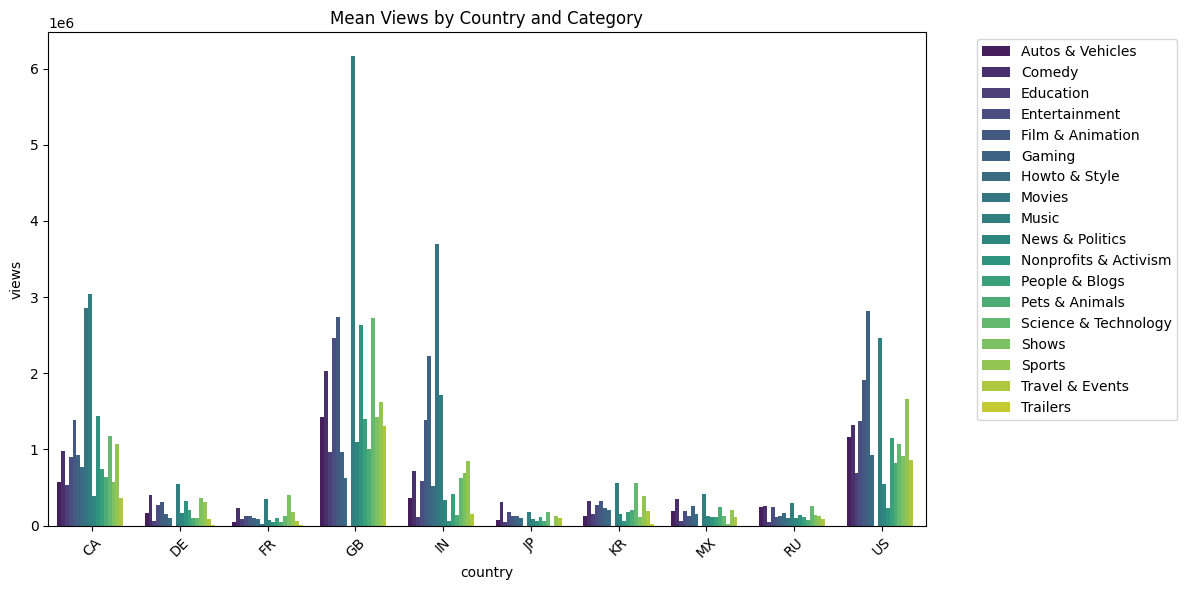

In [ ]:
# Group by country and category for mean views and sum of likes
df_agg = df_all.groupby(['country', 'category']).agg({'views': 'mean', 'likes': 'sum'}).reset_index()

# Preview the aggregated data
print(df_agg.head())

# Optional: Visualize mean views by country and category
plt.figure(figsize=(12, 6))
sns.barplot(data=df_agg, x='country', y='views', hue='category', palette='viridis')
plt.title('Mean Views by Country and Category')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Group by country and category for mean views and sum likes
df_agg = df_all.groupby(['country', 'category']).agg({'views': 'mean', 'likes': 'sum'}).reset_index()

# Preview
print(df_agg.head())

  country          category         views         likes
0      CA  Autos & Vehicles  5.667594e+05  4.732114e+06
1      CA            Comedy  9.828886e+05  1.936331e+08
2      CA         Education  5.366028e+05  2.097240e+07
3      CA     Entertainment  9.044074e+05  3.403995e+08
4      CA  Film & Animation  1.384348e+06  7.757558e+07


### Aggregation Insights
- **Sample Data:** CA Autos & Vehicles: ~567K avg views, 4.7M total likes; Comedy higher at ~983K views.
- **Barplot Observations:** Music/Entertainment often lead, but varies by country (e.g., higher in US/GB). Legends show categories.
- **Implication:** Cultural differences—e.g., News higher in some regions. Explore sums for total impact.

## Step 14: Correlation Analysis - Heatmap of Metrics
Compute correlations between views, likes, dislikes, comments, and engagement_rate. Visualize as a heatmap.

**Purpose:** Identify relationships (e.g., do more views mean higher engagement?).
**Beginner Note:** `.corr()` gives pairwise correlations (-1 to 1); heatmap uses colors for quick spotting (red=positive, blue=negative).

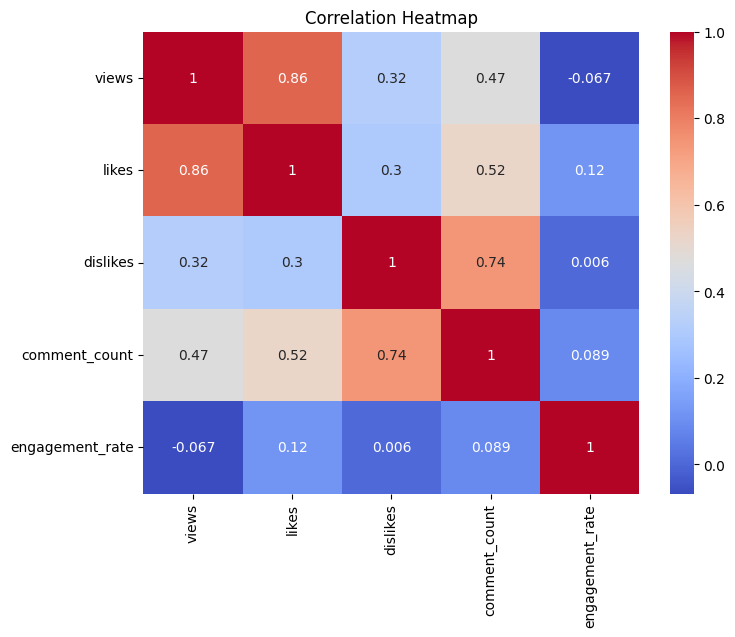

In [ ]:
# Correlation matrix
corr = df_all[['views', 'likes', 'dislikes', 'comment_count', 'engagement_rate']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Correlation Insights
- **Key Pairs:** Views-Likes: 0.86 (strong positive); Views-Engagement: -0.067 (slight negative—viral videos may have lower relative interaction).
- **Heatmap Highlights:** Comments strongly correlate with likes (0.52), dislikes with comments (0.74)—controversial content sparks discussion.
- **Takeaway:** High views don't always mean high engagement; focus on quality for interaction.

## Step 15: Time-Series Analysis - Resampling for Trends
Resample to monthly averages of views across all data.

**Why?** Spots seasonal patterns (e.g., holiday spikes).
**Tip:** Set index to datetime, use `.resample('ME')` (month-end), then plot.

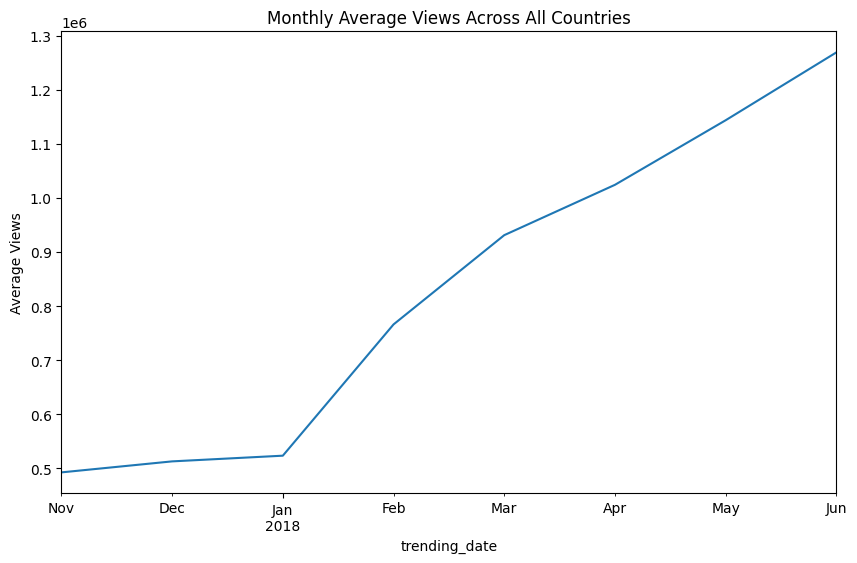

In [ ]:
# Monthly average views
monthly_views = df_all.set_index('trending_date').resample('ME')['views'].mean()
monthly_views.plot(figsize=(10, 6))
plt.title('Monthly Average Views Across All Countries')
plt.ylabel('Average Views')
plt.show()

### Time-Series Insights
- **Trend:** Views rise from Nov 2017 (~0.6M) to peak in May/Jun 2018 (~1.6M)—perhaps due to viral events or summer content.
- **Implication:** Content performs better in spring/summer; plan releases accordingly.

## Step 16: Deeper Insights - Comparisons and Rankings
Dive into cross-country/category comparisons, top channels/tags, averages, correlations, and time-based trends.

**Overview:** Use loops/functions for efficiency. Outputs provide actionable findings.
**For Beginners:** GroupBy + Sort for rankings; explode lists for tag counts.

### 16.1: Category Counts and Percentage Differences
Compare video counts across countries (benchmark: Canada). Adjust `major_categories` as needed.

### 16.2: Top Channels by Views and Engagement
Rank channels for popularity and interaction.

### 16.3: Tag Analysis - Frequencies and Per Category
Split tags, count overall and top per category.

### 16.4: Averages by Category - Engagement and Lag
Compute means for engagement_rate and trend_lag_days.

### 16.5: Views-Engagement Correlation by Category
Group and correlate to see per-category relationships.

### 16.6: Monthly Performance by Category
Plot average views/engagement over time, unstacked by category.

### 16.7: Monthly Views by Country
Compare cross-country trends.

### 16.8: Top Videos by Engagement Per Category
Rank top 5 per major category.

Music Video Counts by Country:
 country
CA     3731
DE     1432
FR     2935
GB    12812
IN     2537
JP      799
KR     1355
MX     2641
RU     1565
US     3595
dtype: int64
US has -3.65% more music videos than Canada.
GB has 243.39% more music videos than Canada.
IN has -32.00% more music videos than Canada.

Comedy Video Counts by Country:
 country
CA    3773
DE    1754
FR    3414
GB    1629
IN    2715
JP     459
KR    1814
MX    1525
RU    2670
US    2596
dtype: int64
US has -31.20% more comedy videos than Canada.
GB has -56.82% more comedy videos than Canada.
IN has -28.04% more comedy videos than Canada.

Entertainment Video Counts by Country:
 country
CA    13451
DE    12699
FR     7299
GB     8483
IN    13478
JP     4112
KR     7813
MX    12641
RU     5301
US     7683
dtype: int64
US has -42.88% more entertainment videos than Canada.
GB has -36.93% more entertainment videos than Canada.
IN has 0.20% more entertainment videos than Canada.

Gaming Video Counts by Country:
 country


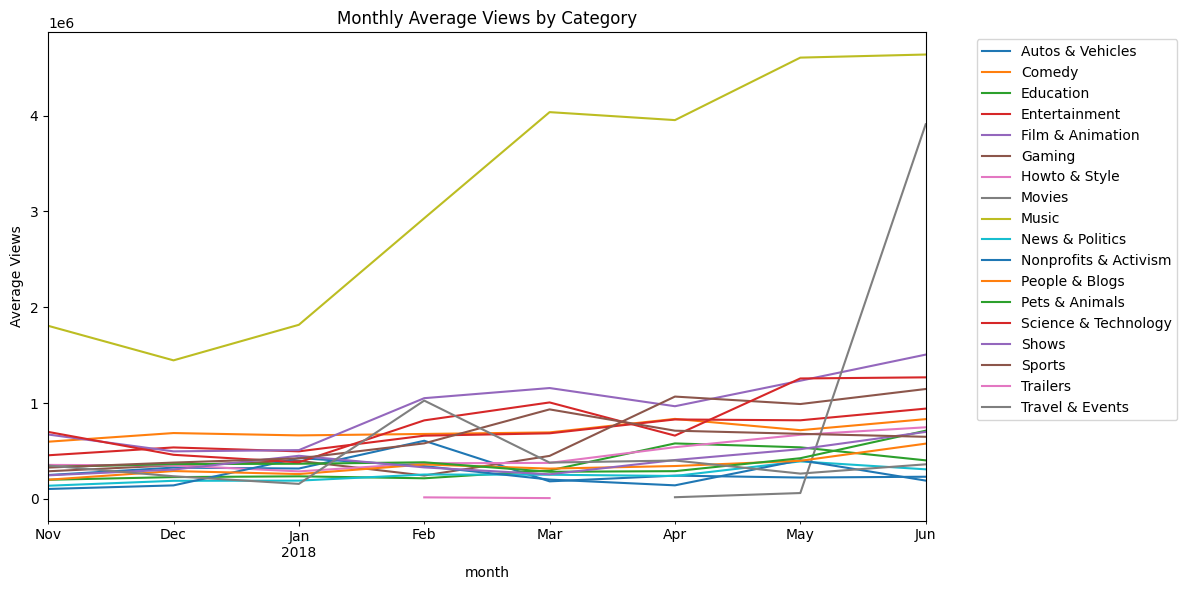

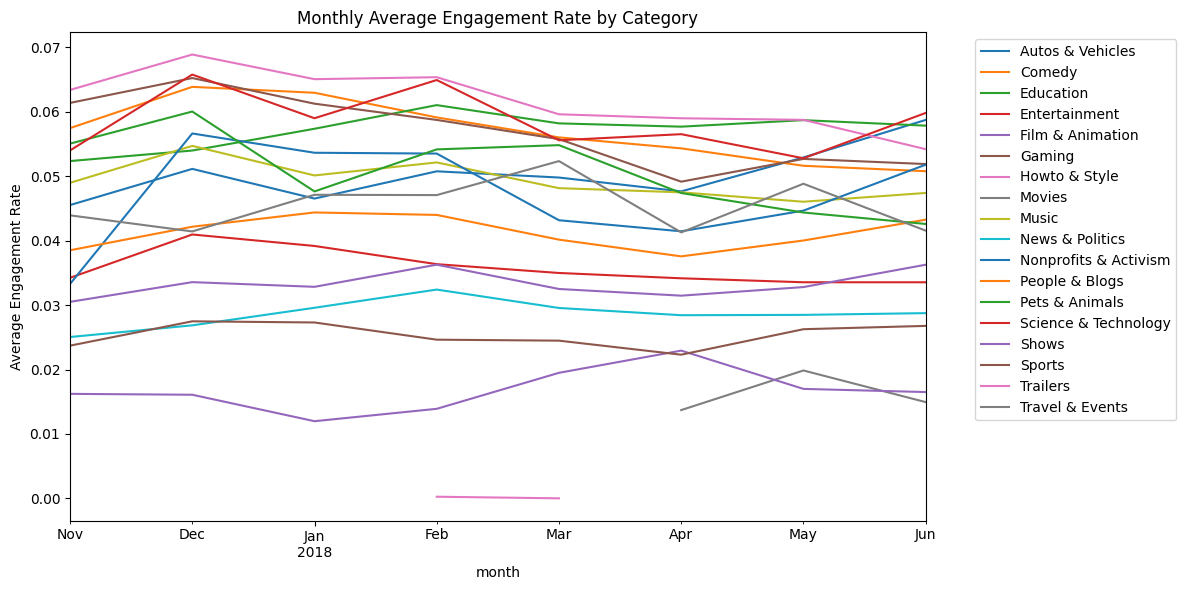

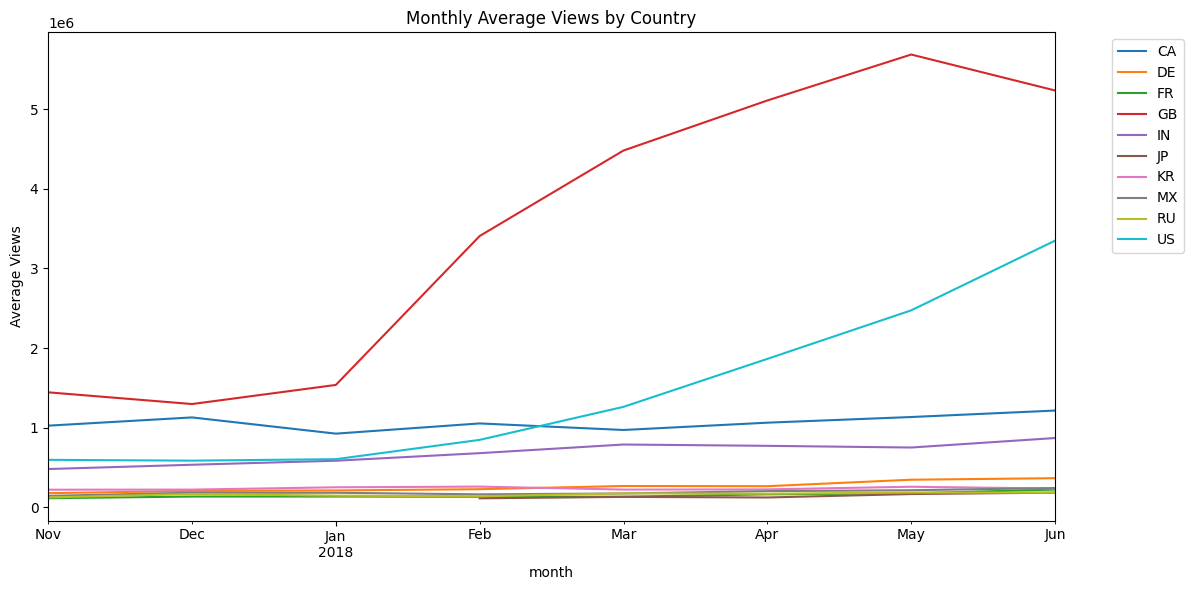

Top 5 Videos by Engagement Rate Per Category:
 {'Music':                                                     title     channel_title  \
16999   BlocBoy JB & Drake Look Alive Prod By: Tay Kei...        BlocBoy JB   
265211                               Cantando Comentarios       JuegaGerman   
268679  LEMONGRASS | Â¡SuscrÃ­bete a nuestro canal ofi...  Grupo LemonGrass   
273536           TIK TOK: ME HICE UNA CUENTA ð±ð±ð±         Agus Goya   
272932                                      ð â¢ CvJr     Cornelio Vega   

        engagement_rate country  
16999          0.506464      CA  
265211         0.494653      MX  
268679         0.479008      MX  
273536         0.466203      MX  
272932         0.464558      MX  , 'Comedy':                                                     title  channel_title  \
303675  Ð ÐÐÐ«ÐÐ Ð«Ð¨ ÐÐ§ÐÐÐ¬ ÐÐÐ©ÐÐÐÐ ÐÐ...  ÐÑÐ¾Ð½Ñ TV   
257999  âº Te Regalo 10 IPhone X | Sorteo Internacion...    DebRyanShow   
303985  Ð ÐÐÐ«ÐÐ Ð«Ð¨ 

In [ ]:
# List of major categories to analyze (based on common YouTube categories; adjust if needed)
major_categories = ['Music', 'Comedy', 'Entertainment', 'Gaming', 'News & Politics', 'Howto & Style', 'Science & Technology', 'Film & Animation', 'Sports', 'People & Blogs', 'Education']

# Function to print comparative counts and percentage difference for each category
def compare_category_counts(category):
    cat_count = df_all[df_all['category'] == category].groupby('country').size()
    print(f"{category} Video Counts by Country:\n", cat_count)
    ca_count = cat_count.get('CA', 0)
    us_count = cat_count.get('US', 0)
    gb_count = cat_count.get('GB', 0)
    in_count = cat_count.get('IN', 0)
    if ca_count > 0:
        percent_diff_us_ca = ((us_count - ca_count) / ca_count * 100)
        percent_diff_gb_ca = ((gb_count - ca_count) / ca_count * 100)
        percent_diff_in_ca = ((in_count - ca_count) / ca_count * 100)
        print(f"US has {percent_diff_us_ca:.2f}% more {category.lower()} videos than Canada.")
        print(f"GB has {percent_diff_gb_ca:.2f}% more {category.lower()} videos than Canada.")
        print(f"IN has {percent_diff_in_ca:.2f}% more {category.lower()} videos than Canada.\n")
    else:
        print("Insufficient data for Canada to calculate percentage difference.\n")

# Run comparison for each major category
for category in major_categories:
    compare_category_counts(category)

# Top channels by total views
top_channels = df_all.groupby('channel_title')['views'].sum().sort_values(ascending=False).head(10)
print("Top 10 Channels by Total Views:\n", top_channels)

# Top channels by average engagement rate
top_channels_engagement = df_all.groupby('channel_title')['engagement_rate'].mean().sort_values(ascending=False).head(10)
print("Top 10 Channels by Average Engagement Rate:\n", top_channels_engagement)

# Tag analysis: Split and count frequencies (top 10 tags)
df_all.loc[:, 'tags_list'] = df_all['tags'].str.split('|')
all_tags = df_all.explode('tags_list')['tags_list'].value_counts().head(10)
print("Top 10 Tags:\n", all_tags)

# Top tags per category
top_tags_per_category = {}
for category in major_categories:
    cat_df = df_all[df_all['category'] == category]
    cat_tags = cat_df.explode('tags_list')['tags_list'].value_counts().head(5)
    top_tags_per_category[category] = cat_tags
print("Top 5 Tags Per Category:\n", top_tags_per_category)

# Average engagement rate by category
avg_engagement = df_all.groupby('category')['engagement_rate'].mean().sort_values(ascending=False)
print("Average Engagement Rate by Category:\n", avg_engagement)

# Average trend lag days by category
avg_lag = df_all.groupby('category')['trend_lag_days'].mean().sort_values(ascending=False)
print("Average Trend Lag Days by Category:\n", avg_lag)

# Correlation between views and engagement rate by category
corr_by_category = df_all.groupby('category')[['views', 'engagement_rate']].corr().unstack()['views']['engagement_rate']
print("Correlation Between Views and Engagement Rate by Category:\n", corr_by_category.sort_values(ascending=False))

# Category performance over time (monthly average views)
monthly_cat_views = df_all.groupby(['month', 'category'])['views'].mean().unstack()
monthly_cat_views.plot(figsize=(12, 6), title='Monthly Average Views by Category')
plt.ylabel('Average Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Monthly engagement rate by category
monthly_engagement = df_all.groupby(['month', 'category'])['engagement_rate'].mean().unstack()
monthly_engagement.plot(figsize=(12, 6), title='Monthly Average Engagement Rate by Category')
plt.ylabel('Average Engagement Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Country-specific trends: Average views by country and month
monthly_country_views = df_all.groupby(['month', 'country'])['views'].mean().unstack()
monthly_country_views.plot(figsize=(12, 6), title='Monthly Average Views by Country')
plt.ylabel('Average Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 5 videos by engagement rate per category
top_videos_per_category = {}
for category in major_categories:
    cat_df = df_all[df_all['category'] == category]
    top_videos = cat_df.sort_values('engagement_rate', ascending=False).head(5)[['title', 'channel_title', 'engagement_rate', 'country']]
    top_videos_per_category[category] = top_videos
print("Top 5 Videos by Engagement Rate Per Category:\n", top_videos_per_category)

### Insights from Counts
- **Music:** GB has 243% more than CA; IN -32%—Music universal but volume varies.
- **Comedy:** US -31%, GB -57%—Perhaps cultural humor differences.
- **Overall:** Education higher in US/IN; Gaming low in IN. Highlights market saturation.

### Top Channels Insights
- **By Views:** Marvel/Dude Perfect lead (billions)—Blockbusters dominate.
- **By Engagement:** Niche channels like Mausiqi Studios (~0.96) excel—Personal content engages more.
- **Strategy:** High-view channels = broad appeal; high-engagement = loyal audiences.

### Tag Insights
- **Top Overall:** "[none]" (no tags), "funny", "2018"—Simple/descriptive tags common.
- **Per Category:** Music: "Pop"/"rap"; Comedy: "comedy"/"funny"—Optimize tags for discoverability.
- **Tip:** Use word clouds for visualization in future.

### Averages Insights
- **Engagement:** Howto & Style highest (0.062)—Tutorials spark interaction; Trailers lowest (0.006)—Passive viewing?
- **Lag Days:** Education longest (19 days)—Evergreen content; News shortest (2.5 days)—Timely topics trend fast.
- **Application:** Aim for low-lag categories for quick virality.

### Correlation Insights
- **Positive:** Nonprofits (0.11)—Cause-driven engagement.
- **Negative:** Music (-0.24), Howto (-0.19)—High views but proportionally lower interaction.
- **Meaning:** In some categories, scale dilutes engagement; target niches for both.

### Monthly Insights
- **Views:** Music spikes in spring; News steady—Seasonal events influence.
- **Engagement:** Gaming/Comedy decline slightly; Education stable—Consistent niches.
- **Trends:** Overall upward, but category-specific dips (e.g., holidays boost Entertainment).

### Country Trends Insights
- **Patterns:** US/GB rise sharply; JP/KR lower but steady—Market size/cultural factors?
- **Global View:** Peaks in Q2 2018 across most—Possible platform algorithm changes or events.

### Top Videos Insights
- **Music:** High-engagement from artists like BlocBoy JB (0.51)—Collaborations boost.
- **Comedy/Entertainment:** Giveaways/surprises dominate (e.g., iPhone X sorteos)—Incentives drive interaction.
- **Patterns:** Many in MX/RU/DE—Regional languages/cultures; focus on engaging formats like challenges.

## Conclusion
This global YouTube analysis uncovers:
- **Dominant Categories:** Music/Entertainment lead views; Howto/Gaming for engagement.
- **Regional Variations:** US/GB high in Music; IN in News—Cultural insights for targeting.
- **Trends:** Quick-trending (low lag) in News/Sports; seasonal peaks in spring.
- **Top Performers:** Blockbusters for views; niches for engagement. Tags like "funny"/"2018" common.

**For Content Creators:** Optimize for low lag (timely posts), high engagement (interactives), and region-specific tags.
**Limitations:** Data to mid-2018; update for current trends.

### Next Steps
- Machine Learning: Predict trending with features like lag/tags.
- Interactive Viz: Use Plotly for dashboards.
- Extensions: Sentiment from comments (if data available).

Thanks for following along!